## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [4]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [18]:
## Load in the data set (Internet Access needed)

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(os.path.join('data', 'diabetes.csv'))
diabetes_df.columns = names

In [19]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
365,5,99,54,28,83,34.0,0.499,30,0
370,3,173,82,48,465,38.4,2.137,25,1
147,2,106,64,35,119,30.5,1.400,34,0
133,8,84,74,31,0,38.3,0.457,39,0
284,2,108,80,0,0,27.0,0.259,52,1


In [20]:
diabetes_df[:5]

,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [21]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [22]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [23]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [24]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.776
roc-auc is 0.831


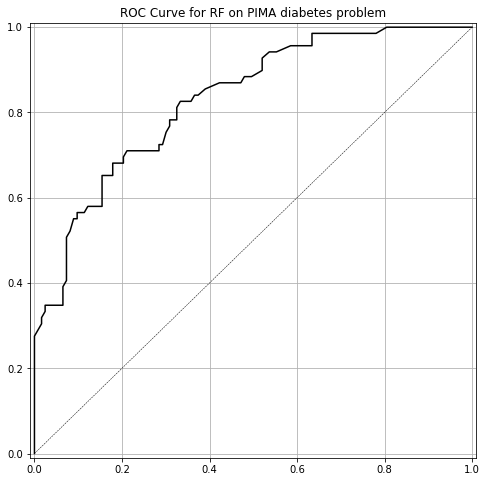

In [26]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [27]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [28]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [29]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [30]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 0s 849us/step - loss: 0.8649 - acc: 0.6354 - val_loss: 0.8960 - val_acc: 0.6302
Epoch 2/200
576/576 [==============================] - 0s 121us/step - loss: 0.8508 - acc: 0.6354 - val_loss: 0.8818 - val_acc: 0.6302
Epoch 3/200
576/576 [==============================] - 0s 79us/step - loss: 0.8375 - acc: 0.6372 - val_loss: 0.8683 - val_acc: 0.6302
Epoch 4/200
576/576 [==============================] - 0s 102us/step - loss: 0.8249 - acc: 0.6372 - val_loss: 0.8555 - val_acc: 0.6354
Epoch 5/200
576/576 [==============================] - 0s 135us/step - loss: 0.8129 - acc: 0.6372 - val_loss: 0.8434 - val_acc: 0.6354
Epoch 6/200
576/576 [==============================] - 0s 97us/step - loss: 0.8014 - acc: 0.6354 - val_loss: 0.8318 - val_acc: 0.6354
Epoch 7/200
576/576 [==============================] - 0s 110us/step - loss: 0.7905 - acc: 0.6372 - val_loss: 0.8208 - val_acc: 0.6354
Epoch 8/200

576/576 [==============================] - 0s 90us/step - loss: 0.5547 - acc: 0.7188 - val_loss: 0.5896 - val_acc: 0.6510
Epoch 62/200
576/576 [==============================] - 0s 83us/step - loss: 0.5529 - acc: 0.7188 - val_loss: 0.5879 - val_acc: 0.6510
Epoch 63/200
576/576 [==============================] - 0s 84us/step - loss: 0.5511 - acc: 0.7188 - val_loss: 0.5863 - val_acc: 0.6562
Epoch 64/200
576/576 [==============================] - 0s 75us/step - loss: 0.5494 - acc: 0.7170 - val_loss: 0.5847 - val_acc: 0.6562
Epoch 65/200
576/576 [==============================] - 0s 110us/step - loss: 0.5477 - acc: 0.7205 - val_loss: 0.5831 - val_acc: 0.6615
Epoch 66/200
576/576 [==============================] - 0s 128us/step - loss: 0.5460 - acc: 0.7222 - val_loss: 0.5816 - val_acc: 0.6615
Epoch 67/200
576/576 [==============================] - 0s 104us/step - loss: 0.5443 - acc: 0.7240 - val_loss: 0.5801 - val_acc: 0.6719
Epoch 68/200
576/576 [==============================] - 0s 98us/s

576/576 [==============================] - 0s 81us/step - loss: 0.4893 - acc: 0.7674 - val_loss: 0.5345 - val_acc: 0.7188
Epoch 122/200
576/576 [==============================] - 0s 106us/step - loss: 0.4886 - acc: 0.7674 - val_loss: 0.5340 - val_acc: 0.7188
Epoch 123/200
576/576 [==============================] - 0s 64us/step - loss: 0.4881 - acc: 0.7674 - val_loss: 0.5336 - val_acc: 0.7188
Epoch 124/200
576/576 [==============================] - 0s 135us/step - loss: 0.4875 - acc: 0.7674 - val_loss: 0.5332 - val_acc: 0.7188
Epoch 125/200
576/576 [==============================] - 0s 142us/step - loss: 0.4869 - acc: 0.7674 - val_loss: 0.5328 - val_acc: 0.7188
Epoch 126/200
576/576 [==============================] - 0s 144us/step - loss: 0.4864 - acc: 0.7674 - val_loss: 0.5324 - val_acc: 0.7188
Epoch 127/200
576/576 [==============================] - 0s 179us/step - loss: 0.4858 - acc: 0.7674 - val_loss: 0.5320 - val_acc: 0.7240
Epoch 128/200
576/576 [==============================] - 

576/576 [==============================] - 0s 92us/step - loss: 0.4671 - acc: 0.7622 - val_loss: 0.5202 - val_acc: 0.7396
Epoch 182/200
576/576 [==============================] - 0s 81us/step - loss: 0.4668 - acc: 0.7622 - val_loss: 0.5201 - val_acc: 0.7396
Epoch 183/200
576/576 [==============================] - 0s 81us/step - loss: 0.4666 - acc: 0.7622 - val_loss: 0.5199 - val_acc: 0.7396
Epoch 184/200
576/576 [==============================] - 0s 71us/step - loss: 0.4664 - acc: 0.7622 - val_loss: 0.5198 - val_acc: 0.7396
Epoch 185/200
576/576 [==============================] - 0s 82us/step - loss: 0.4661 - acc: 0.7639 - val_loss: 0.5197 - val_acc: 0.7396
Epoch 186/200
576/576 [==============================] - 0s 77us/step - loss: 0.4659 - acc: 0.7622 - val_loss: 0.5196 - val_acc: 0.7396
Epoch 187/200
576/576 [==============================] - 0s 73us/step - loss: 0.4657 - acc: 0.7622 - val_loss: 0.5195 - val_acc: 0.7396
Epoch 188/200
576/576 [==============================] - 0s 69

In [31]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [32]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

In [33]:
y_pred_prob_nn_1[:10]

array([[0.55365306],
       [0.53650475],
       [0.38256246],
       [0.42659926],
       [0.14416505],
       [0.47174218],
       [0.04601027],
       [0.41514298],
       [0.8642378 ],
       [0.18176754]], dtype=float32)

accuracy is 0.745
roc-auc is 0.793


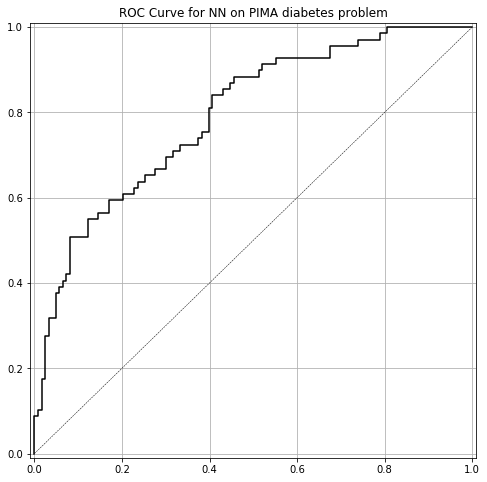

In [34]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [35]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

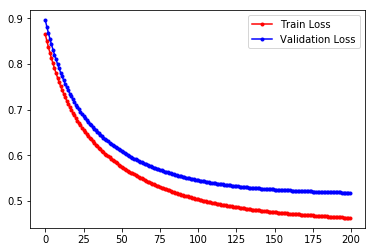

In [36]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [37]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 97us/step - loss: 0.4628 - acc: 0.7656 - val_loss: 0.5181 - val_acc: 0.7448
Epoch 2/1000
576/576 [==============================] - 0s 120us/step - loss: 0.4626 - acc: 0.7656 - val_loss: 0.5181 - val_acc: 0.7448
Epoch 3/1000
576/576 [==============================] - 0s 106us/step - loss: 0.4624 - acc: 0.7674 - val_loss: 0.5180 - val_acc: 0.7448
Epoch 4/1000
576/576 [==============================] - 0s 129us/step - loss: 0.4623 - acc: 0.7656 - val_loss: 0.5179 - val_acc: 0.7448
Epoch 5/1000
576/576 [==============================] - 0s 101us/step - loss: 0.4621 - acc: 0.7656 - val_loss: 0.5178 - val_acc: 0.7448
Epoch 6/1000
576/576 [==============================] - 0s 105us/step - loss: 0.4619 - acc: 0.7674 - val_loss: 0.5177 - val_acc: 0.7448
Epoch 7/1000
576/576 [==============================] - 0s 76us/step - loss: 0.4617 - acc: 0.7691 - val_loss: 0.5177 - val_acc: 0.7448
Epoc

Epoch 61/1000
576/576 [==============================] - 0s 82us/step - loss: 0.4543 - acc: 0.7708 - val_loss: 0.5150 - val_acc: 0.7448
Epoch 62/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4541 - acc: 0.7708 - val_loss: 0.5150 - val_acc: 0.7448
Epoch 63/1000
576/576 [==============================] - 0s 80us/step - loss: 0.4540 - acc: 0.7708 - val_loss: 0.5150 - val_acc: 0.7448
Epoch 64/1000
576/576 [==============================] - 0s 79us/step - loss: 0.4539 - acc: 0.7708 - val_loss: 0.5149 - val_acc: 0.7448
Epoch 65/1000
576/576 [==============================] - 0s 59us/step - loss: 0.4538 - acc: 0.7708 - val_loss: 0.5149 - val_acc: 0.7448
Epoch 66/1000
576/576 [==============================] - 0s 80us/step - loss: 0.4537 - acc: 0.7691 - val_loss: 0.5149 - val_acc: 0.7448
Epoch 67/1000
576/576 [==============================] - 0s 75us/step - loss: 0.4536 - acc: 0.7708 - val_loss: 0.5149 - val_acc: 0.7448
Epoch 68/1000
576/576 [=========================

576/576 [==============================] - 0s 69us/step - loss: 0.4484 - acc: 0.7691 - val_loss: 0.5140 - val_acc: 0.7448
Epoch 122/1000
576/576 [==============================] - 0s 65us/step - loss: 0.4483 - acc: 0.7708 - val_loss: 0.5140 - val_acc: 0.7448
Epoch 123/1000
576/576 [==============================] - 0s 80us/step - loss: 0.4482 - acc: 0.7708 - val_loss: 0.5140 - val_acc: 0.7448
Epoch 124/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4481 - acc: 0.7708 - val_loss: 0.5140 - val_acc: 0.7448
Epoch 125/1000
576/576 [==============================] - 0s 79us/step - loss: 0.4480 - acc: 0.7708 - val_loss: 0.5140 - val_acc: 0.7448
Epoch 126/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4480 - acc: 0.7708 - val_loss: 0.5140 - val_acc: 0.7448
Epoch 127/1000
576/576 [==============================] - 0s 78us/step - loss: 0.4479 - acc: 0.7708 - val_loss: 0.5140 - val_acc: 0.7448
Epoch 128/1000
576/576 [==============================] 

Epoch 181/1000
576/576 [==============================] - 0s 97us/step - loss: 0.4440 - acc: 0.7691 - val_loss: 0.5140 - val_acc: 0.7396
Epoch 182/1000
576/576 [==============================] - 0s 109us/step - loss: 0.4440 - acc: 0.7691 - val_loss: 0.5140 - val_acc: 0.7396
Epoch 183/1000
576/576 [==============================] - 0s 113us/step - loss: 0.4439 - acc: 0.7691 - val_loss: 0.5140 - val_acc: 0.7396
Epoch 184/1000
576/576 [==============================] - 0s 79us/step - loss: 0.4438 - acc: 0.7691 - val_loss: 0.5140 - val_acc: 0.7396
Epoch 185/1000
576/576 [==============================] - 0s 81us/step - loss: 0.4438 - acc: 0.7691 - val_loss: 0.5140 - val_acc: 0.7396
Epoch 186/1000
576/576 [==============================] - 0s 68us/step - loss: 0.4437 - acc: 0.7691 - val_loss: 0.5141 - val_acc: 0.7396
Epoch 187/1000
576/576 [==============================] - 0s 72us/step - loss: 0.4437 - acc: 0.7691 - val_loss: 0.5141 - val_acc: 0.7396
Epoch 188/1000
576/576 [===============

576/576 [==============================] - 0s 119us/step - loss: 0.4406 - acc: 0.7691 - val_loss: 0.5147 - val_acc: 0.7500
Epoch 241/1000
576/576 [==============================] - 0s 94us/step - loss: 0.4405 - acc: 0.7708 - val_loss: 0.5147 - val_acc: 0.7500
Epoch 242/1000
576/576 [==============================] - 0s 124us/step - loss: 0.4405 - acc: 0.7708 - val_loss: 0.5147 - val_acc: 0.7500
Epoch 243/1000
576/576 [==============================] - 0s 114us/step - loss: 0.4404 - acc: 0.7708 - val_loss: 0.5147 - val_acc: 0.7500
Epoch 244/1000
576/576 [==============================] - 0s 82us/step - loss: 0.4404 - acc: 0.7726 - val_loss: 0.5147 - val_acc: 0.7500
Epoch 245/1000
576/576 [==============================] - 0s 96us/step - loss: 0.4403 - acc: 0.7708 - val_loss: 0.5147 - val_acc: 0.7500
Epoch 246/1000
576/576 [==============================] - 0s 74us/step - loss: 0.4403 - acc: 0.7726 - val_loss: 0.5148 - val_acc: 0.7500
Epoch 247/1000
576/576 [=============================

Epoch 300/1000
576/576 [==============================] - 0s 98us/step - loss: 0.4380 - acc: 0.7760 - val_loss: 0.5156 - val_acc: 0.7604
Epoch 301/1000
576/576 [==============================] - 0s 111us/step - loss: 0.4379 - acc: 0.7743 - val_loss: 0.5156 - val_acc: 0.7604
Epoch 302/1000
576/576 [==============================] - 0s 100us/step - loss: 0.4379 - acc: 0.7760 - val_loss: 0.5156 - val_acc: 0.7604
Epoch 303/1000
576/576 [==============================] - 0s 81us/step - loss: 0.4378 - acc: 0.7760 - val_loss: 0.5156 - val_acc: 0.7604
Epoch 304/1000
576/576 [==============================] - 0s 109us/step - loss: 0.4378 - acc: 0.7743 - val_loss: 0.5156 - val_acc: 0.7604
Epoch 305/1000
576/576 [==============================] - 0s 62us/step - loss: 0.4378 - acc: 0.7760 - val_loss: 0.5157 - val_acc: 0.7604
Epoch 306/1000
576/576 [==============================] - 0s 92us/step - loss: 0.4377 - acc: 0.7760 - val_loss: 0.5157 - val_acc: 0.7604
Epoch 307/1000
576/576 [==============

576/576 [==============================] - 0s 92us/step - loss: 0.4356 - acc: 0.7795 - val_loss: 0.5165 - val_acc: 0.7500
Epoch 360/1000
576/576 [==============================] - 0s 56us/step - loss: 0.4356 - acc: 0.7778 - val_loss: 0.5165 - val_acc: 0.7500
Epoch 361/1000
576/576 [==============================] - 0s 53us/step - loss: 0.4356 - acc: 0.7778 - val_loss: 0.5165 - val_acc: 0.7500
Epoch 362/1000
576/576 [==============================] - 0s 75us/step - loss: 0.4355 - acc: 0.7795 - val_loss: 0.5165 - val_acc: 0.7500
Epoch 363/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4355 - acc: 0.7795 - val_loss: 0.5165 - val_acc: 0.7500
Epoch 364/1000
576/576 [==============================] - 0s 69us/step - loss: 0.4354 - acc: 0.7795 - val_loss: 0.5165 - val_acc: 0.7500
Epoch 365/1000
576/576 [==============================] - 0s 72us/step - loss: 0.4354 - acc: 0.7795 - val_loss: 0.5165 - val_acc: 0.7500
Epoch 366/1000
576/576 [==============================] 

Epoch 419/1000
576/576 [==============================] - 0s 99us/step - loss: 0.4337 - acc: 0.7830 - val_loss: 0.5166 - val_acc: 0.7500
Epoch 420/1000
576/576 [==============================] - 0s 97us/step - loss: 0.4336 - acc: 0.7830 - val_loss: 0.5166 - val_acc: 0.7500
Epoch 421/1000
576/576 [==============================] - 0s 117us/step - loss: 0.4336 - acc: 0.7830 - val_loss: 0.5166 - val_acc: 0.7500
Epoch 422/1000
576/576 [==============================] - 0s 121us/step - loss: 0.4336 - acc: 0.7812 - val_loss: 0.5166 - val_acc: 0.7500
Epoch 423/1000
576/576 [==============================] - 0s 89us/step - loss: 0.4336 - acc: 0.7812 - val_loss: 0.5166 - val_acc: 0.7500
Epoch 424/1000
576/576 [==============================] - 0s 84us/step - loss: 0.4335 - acc: 0.7830 - val_loss: 0.5166 - val_acc: 0.7500
Epoch 425/1000
576/576 [==============================] - 0s 65us/step - loss: 0.4335 - acc: 0.7830 - val_loss: 0.5166 - val_acc: 0.7500
Epoch 426/1000
576/576 [===============

Epoch 479/1000
576/576 [==============================] - 0s 105us/step - loss: 0.4319 - acc: 0.7847 - val_loss: 0.5168 - val_acc: 0.7552
Epoch 480/1000
576/576 [==============================] - 0s 101us/step - loss: 0.4319 - acc: 0.7847 - val_loss: 0.5168 - val_acc: 0.7552
Epoch 481/1000
576/576 [==============================] - 0s 120us/step - loss: 0.4319 - acc: 0.7865 - val_loss: 0.5168 - val_acc: 0.7552
Epoch 482/1000
576/576 [==============================] - 0s 88us/step - loss: 0.4318 - acc: 0.7865 - val_loss: 0.5168 - val_acc: 0.7552
Epoch 483/1000
576/576 [==============================] - 0s 98us/step - loss: 0.4318 - acc: 0.7865 - val_loss: 0.5168 - val_acc: 0.7552
Epoch 484/1000
576/576 [==============================] - 0s 67us/step - loss: 0.4318 - acc: 0.7865 - val_loss: 0.5168 - val_acc: 0.7552
Epoch 485/1000
576/576 [==============================] - 0s 113us/step - loss: 0.4317 - acc: 0.7865 - val_loss: 0.5168 - val_acc: 0.7552
Epoch 486/1000
576/576 [=============

576/576 [==============================] - 0s 128us/step - loss: 0.4303 - acc: 0.7865 - val_loss: 0.5171 - val_acc: 0.7552
Epoch 539/1000
576/576 [==============================] - 0s 92us/step - loss: 0.4303 - acc: 0.7865 - val_loss: 0.5171 - val_acc: 0.7552
Epoch 540/1000
576/576 [==============================] - 0s 111us/step - loss: 0.4303 - acc: 0.7865 - val_loss: 0.5171 - val_acc: 0.7552
Epoch 541/1000
576/576 [==============================] - 0s 144us/step - loss: 0.4302 - acc: 0.7865 - val_loss: 0.5172 - val_acc: 0.7552
Epoch 542/1000
576/576 [==============================] - 0s 122us/step - loss: 0.4302 - acc: 0.7865 - val_loss: 0.5172 - val_acc: 0.7552
Epoch 543/1000
576/576 [==============================] - 0s 101us/step - loss: 0.4302 - acc: 0.7865 - val_loss: 0.5172 - val_acc: 0.7552
Epoch 544/1000
576/576 [==============================] - 0s 176us/step - loss: 0.4301 - acc: 0.7865 - val_loss: 0.5172 - val_acc: 0.7552
Epoch 545/1000
576/576 [==========================

576/576 [==============================] - 0s 173us/step - loss: 0.4287 - acc: 0.7830 - val_loss: 0.5176 - val_acc: 0.7500
Epoch 598/1000
576/576 [==============================] - 0s 152us/step - loss: 0.4287 - acc: 0.7830 - val_loss: 0.5176 - val_acc: 0.7500
Epoch 599/1000
576/576 [==============================] - 0s 114us/step - loss: 0.4287 - acc: 0.7830 - val_loss: 0.5176 - val_acc: 0.7500
Epoch 600/1000
576/576 [==============================] - 0s 154us/step - loss: 0.4286 - acc: 0.7830 - val_loss: 0.5176 - val_acc: 0.7500
Epoch 601/1000
576/576 [==============================] - 0s 131us/step - loss: 0.4286 - acc: 0.7830 - val_loss: 0.5176 - val_acc: 0.7500
Epoch 602/1000
576/576 [==============================] - 0s 142us/step - loss: 0.4286 - acc: 0.7830 - val_loss: 0.5176 - val_acc: 0.7500
Epoch 603/1000
576/576 [==============================] - 0s 155us/step - loss: 0.4286 - acc: 0.7830 - val_loss: 0.5176 - val_acc: 0.7500
Epoch 604/1000
576/576 [=========================

576/576 [==============================] - 0s 140us/step - loss: 0.4273 - acc: 0.7865 - val_loss: 0.5182 - val_acc: 0.7500
Epoch 657/1000
576/576 [==============================] - 0s 95us/step - loss: 0.4272 - acc: 0.7865 - val_loss: 0.5182 - val_acc: 0.7500
Epoch 658/1000
576/576 [==============================] - 0s 125us/step - loss: 0.4272 - acc: 0.7865 - val_loss: 0.5182 - val_acc: 0.7500
Epoch 659/1000
576/576 [==============================] - 0s 110us/step - loss: 0.4272 - acc: 0.7865 - val_loss: 0.5182 - val_acc: 0.7500
Epoch 660/1000
576/576 [==============================] - 0s 103us/step - loss: 0.4272 - acc: 0.7865 - val_loss: 0.5182 - val_acc: 0.7500
Epoch 661/1000
576/576 [==============================] - 0s 141us/step - loss: 0.4271 - acc: 0.7847 - val_loss: 0.5182 - val_acc: 0.7500
Epoch 662/1000
576/576 [==============================] - 0s 127us/step - loss: 0.4271 - acc: 0.7865 - val_loss: 0.5182 - val_acc: 0.7500
Epoch 663/1000
576/576 [==========================

576/576 [==============================] - 0s 146us/step - loss: 0.4258 - acc: 0.7847 - val_loss: 0.5187 - val_acc: 0.7500
Epoch 716/1000
576/576 [==============================] - 0s 91us/step - loss: 0.4258 - acc: 0.7847 - val_loss: 0.5187 - val_acc: 0.7500
Epoch 717/1000
576/576 [==============================] - 0s 77us/step - loss: 0.4257 - acc: 0.7847 - val_loss: 0.5187 - val_acc: 0.7500
Epoch 718/1000
576/576 [==============================] - 0s 68us/step - loss: 0.4257 - acc: 0.7847 - val_loss: 0.5188 - val_acc: 0.7500
Epoch 719/1000
576/576 [==============================] - 0s 78us/step - loss: 0.4257 - acc: 0.7847 - val_loss: 0.5188 - val_acc: 0.7500
Epoch 720/1000
576/576 [==============================] - 0s 82us/step - loss: 0.4257 - acc: 0.7847 - val_loss: 0.5188 - val_acc: 0.7500
Epoch 721/1000
576/576 [==============================] - 0s 77us/step - loss: 0.4257 - acc: 0.7847 - val_loss: 0.5188 - val_acc: 0.7500
Epoch 722/1000
576/576 [==============================]

Epoch 775/1000
576/576 [==============================] - 0s 103us/step - loss: 0.4244 - acc: 0.7865 - val_loss: 0.5194 - val_acc: 0.7448
Epoch 776/1000
576/576 [==============================] - 0s 72us/step - loss: 0.4244 - acc: 0.7865 - val_loss: 0.5194 - val_acc: 0.7448
Epoch 777/1000
576/576 [==============================] - 0s 86us/step - loss: 0.4243 - acc: 0.7865 - val_loss: 0.5194 - val_acc: 0.7448
Epoch 778/1000
576/576 [==============================] - 0s 76us/step - loss: 0.4243 - acc: 0.7865 - val_loss: 0.5194 - val_acc: 0.7448
Epoch 779/1000
576/576 [==============================] - 0s 86us/step - loss: 0.4243 - acc: 0.7865 - val_loss: 0.5194 - val_acc: 0.7448
Epoch 780/1000
576/576 [==============================] - 0s 86us/step - loss: 0.4243 - acc: 0.7865 - val_loss: 0.5194 - val_acc: 0.7448
Epoch 781/1000
576/576 [==============================] - 0s 86us/step - loss: 0.4242 - acc: 0.7865 - val_loss: 0.5194 - val_acc: 0.7448
Epoch 782/1000
576/576 [================

576/576 [==============================] - 0s 180us/step - loss: 0.4229 - acc: 0.7882 - val_loss: 0.5202 - val_acc: 0.7448
Epoch 835/1000
576/576 [==============================] - 0s 100us/step - loss: 0.4229 - acc: 0.7899 - val_loss: 0.5202 - val_acc: 0.7448
Epoch 836/1000
576/576 [==============================] - 0s 140us/step - loss: 0.4229 - acc: 0.7899 - val_loss: 0.5202 - val_acc: 0.7448
Epoch 837/1000
576/576 [==============================] - 0s 122us/step - loss: 0.4229 - acc: 0.7865 - val_loss: 0.5203 - val_acc: 0.7448
Epoch 838/1000
576/576 [==============================] - 0s 106us/step - loss: 0.4228 - acc: 0.7865 - val_loss: 0.5203 - val_acc: 0.7448
Epoch 839/1000
576/576 [==============================] - 0s 123us/step - loss: 0.4228 - acc: 0.7899 - val_loss: 0.5203 - val_acc: 0.7448
Epoch 840/1000
576/576 [==============================] - 0s 148us/step - loss: 0.4228 - acc: 0.7882 - val_loss: 0.5203 - val_acc: 0.7448
Epoch 841/1000
576/576 [=========================

576/576 [==============================] - 0s 135us/step - loss: 0.4215 - acc: 0.7917 - val_loss: 0.5209 - val_acc: 0.7448
Epoch 894/1000
576/576 [==============================] - 0s 91us/step - loss: 0.4215 - acc: 0.7917 - val_loss: 0.5209 - val_acc: 0.7448
Epoch 895/1000
576/576 [==============================] - 0s 97us/step - loss: 0.4214 - acc: 0.7917 - val_loss: 0.5209 - val_acc: 0.7448
Epoch 896/1000
576/576 [==============================] - 0s 76us/step - loss: 0.4214 - acc: 0.7917 - val_loss: 0.5209 - val_acc: 0.7448
Epoch 897/1000
576/576 [==============================] - 0s 90us/step - loss: 0.4214 - acc: 0.7917 - val_loss: 0.5209 - val_acc: 0.7448
Epoch 898/1000
576/576 [==============================] - 0s 81us/step - loss: 0.4214 - acc: 0.7917 - val_loss: 0.5209 - val_acc: 0.7448
Epoch 899/1000
576/576 [==============================] - 0s 91us/step - loss: 0.4213 - acc: 0.7917 - val_loss: 0.5209 - val_acc: 0.7448
Epoch 900/1000
576/576 [==============================]

576/576 [==============================] - 0s 96us/step - loss: 0.4201 - acc: 0.7934 - val_loss: 0.5213 - val_acc: 0.7448
Epoch 953/1000
576/576 [==============================] - 0s 100us/step - loss: 0.4201 - acc: 0.7917 - val_loss: 0.5214 - val_acc: 0.7448
Epoch 954/1000
576/576 [==============================] - 0s 92us/step - loss: 0.4201 - acc: 0.7917 - val_loss: 0.5214 - val_acc: 0.7448
Epoch 955/1000
576/576 [==============================] - 0s 86us/step - loss: 0.4200 - acc: 0.7917 - val_loss: 0.5214 - val_acc: 0.7448
Epoch 956/1000
576/576 [==============================] - 0s 88us/step - loss: 0.4200 - acc: 0.7917 - val_loss: 0.5214 - val_acc: 0.7448
Epoch 957/1000
576/576 [==============================] - 0s 91us/step - loss: 0.4200 - acc: 0.7917 - val_loss: 0.5214 - val_acc: 0.7448
Epoch 958/1000
576/576 [==============================] - 0s 102us/step - loss: 0.4200 - acc: 0.7917 - val_loss: 0.5214 - val_acc: 0.7448
Epoch 959/1000
576/576 [==============================

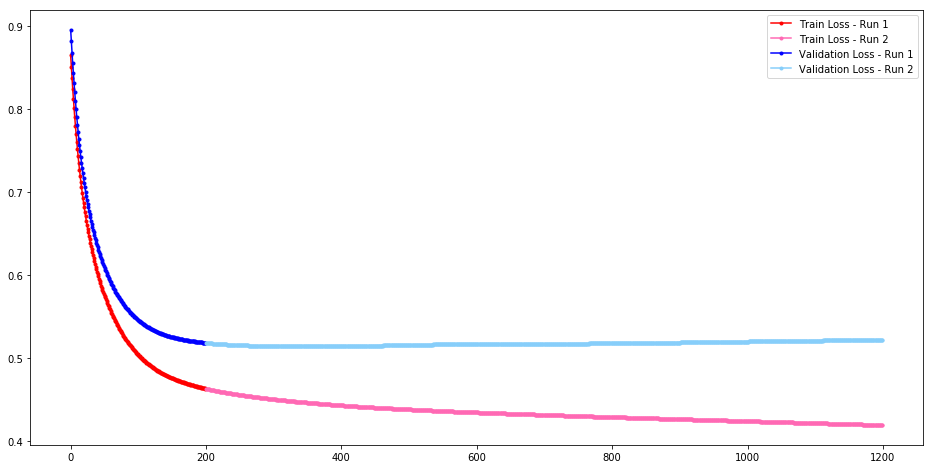

In [38]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [ ]:
# Type your code here to with layer 1,2 having activation relu and layer 3 with activation sigmoid

In [54]:
model = Sequential()
model.add(Dense(6, input_shape = (8,), activation = 'relu'))
model.add(Dense(6, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(SGD(lr = .003), loss="binary_crossentropy", metrics=["accuracy"])

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500, verbose=0)

In [ ]:
# Type your code here to plot the loss accuracy and ROC curve

In [47]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

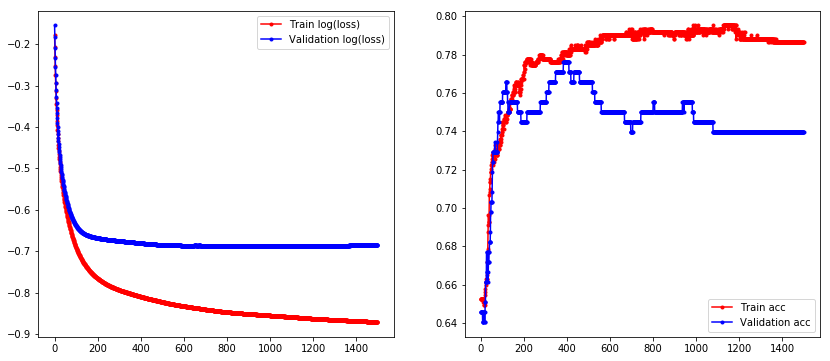

In [62]:
figures, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(np.log(history.history["loss"]),'r', marker='.', label="Train log(loss)")
axes[0].plot(np.log(history.history["val_loss"]),'b', marker='.', label="Validation log(loss)")
axes[0].legend()
axes[1].plot(history.history["acc"],'r', marker='.', label="Train acc")
axes[1].plot(history.history["val_acc"],'b', marker='.', label="Validation acc")
axes[1].legend()
plt.show()